<a href="https://colab.research.google.com/github/Niha0309/Assigments-Machine-Learning/blob/main/features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/assignment1/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/assignment1

Mounted at /content/drive
/content/drive/My Drive/assignment1/cs231n/datasets
/content/drive/My Drive/assignment1


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# autoreload REMOVED because it does not work on Python 3.12+


In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = np.geomspace(1e-4, 1e-2, 3)
regularization_strengths = np.geomspace(0.01, 1, 3)

results = {}
best_val = -1
best_svm = None



import itertools

for lr, reg in itertools.product(learning_rates, regularization_strengths):
    # Create SVM and train it
    svm = LinearSVM()
    svm.train(X_train_feats, y_train, lr, reg, num_iters=1500)

    # Compute training and validation sets accuracies and append to the dictionary
    y_train_pred, y_val_pred = svm.predict(X_train_feats), svm.predict(X_val_feats)
    results[(lr, reg)] = np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred)

    # Save if validation accuracy is the best
    if results[(lr, reg)][1] > best_val:
        best_val = results[(lr, reg)][1]
        best_svm = svm

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved: %f' % best_val)


lr 1.000000e-04 reg 1.000000e-02 train accuracy: 0.449673 val accuracy: 0.444000
lr 1.000000e-04 reg 1.000000e-01 train accuracy: 0.451776 val accuracy: 0.443000
lr 1.000000e-04 reg 1.000000e+00 train accuracy: 0.450000 val accuracy: 0.443000
lr 1.000000e-03 reg 1.000000e-02 train accuracy: 0.500551 val accuracy: 0.485000
lr 1.000000e-03 reg 1.000000e-01 train accuracy: 0.500571 val accuracy: 0.487000
lr 1.000000e-03 reg 1.000000e+00 train accuracy: 0.483429 val accuracy: 0.468000
lr 1.000000e-02 reg 1.000000e-02 train accuracy: 0.507388 val accuracy: 0.493000
lr 1.000000e-02 reg 1.000000e-01 train accuracy: 0.505306 val accuracy: 0.482000
lr 1.000000e-02 reg 1.000000e+00 train accuracy: 0.478122 val accuracy: 0.482000
best validation accuracy achieved: 0.493000


In [6]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.484


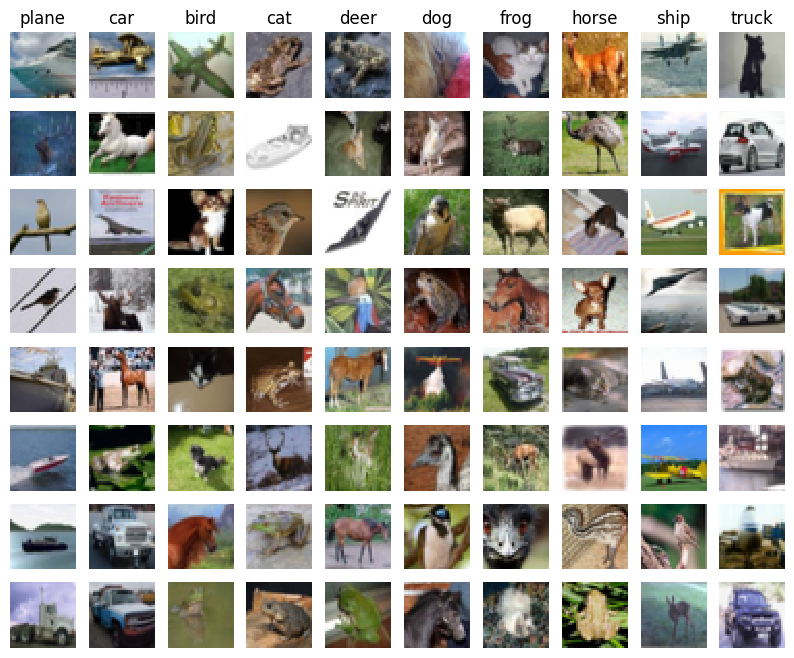

In [7]:
examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

In [8]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [9]:
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

results = {}
best_val = -1

learning_rates = np.linspace(1e-2, 2.75e-2, 4)
regularization_strengths = np.geomspace(1e-6, 1e-4, 3)

data = {
    'X_train': X_train_feats,
    'X_val': X_val_feats,
    'X_test': X_test_feats,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test
}

import itertools

for lr, reg in itertools.product(learning_rates, regularization_strengths):
    # Create Two Layer Net and train it with Solver
    model = net
    solver = Solver(model, data, optim_config={'learning_rate': lr}, num_epochs=15, verbose=False)
    solver.train()

    # Compute validation set accuracy and append to the dictionary
    results[(lr, reg)] = solver.best_val_acc

    # Save if validation accuracy is the best
    if results[(lr, reg)] > best_val:
        best_val = results[(lr, reg)]
        best_net = model

# Print out results.
for lr, reg in sorted(results):
    val_accuracy = results[(lr, reg)]
    print('lr %e reg %e val accuracy: %f' % (lr, reg, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)



lr 1.000000e-02 reg 1.000000e-06 val accuracy: 0.517000
lr 1.000000e-02 reg 1.000000e-05 val accuracy: 0.546000
lr 1.000000e-02 reg 1.000000e-04 val accuracy: 0.566000
lr 1.583333e-02 reg 1.000000e-06 val accuracy: 0.592000
lr 1.583333e-02 reg 1.000000e-05 val accuracy: 0.608000
lr 1.583333e-02 reg 1.000000e-04 val accuracy: 0.603000
lr 2.166667e-02 reg 1.000000e-06 val accuracy: 0.603000
lr 2.166667e-02 reg 1.000000e-05 val accuracy: 0.607000
lr 2.166667e-02 reg 1.000000e-04 val accuracy: 0.607000
lr 2.750000e-02 reg 1.000000e-06 val accuracy: 0.609000
lr 2.750000e-02 reg 1.000000e-05 val accuracy: 0.608000
lr 2.750000e-02 reg 1.000000e-04 val accuracy: 0.606000
best validation accuracy achieved during cross-validation: 0.609000


In [10]:
y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.581
